In [1]:
import numpy as np
import tensorflow as tf

In [2]:
DATA_DIR = "../data/"

n_input = 29
n_classes = 2
learning_rate = 0.0005
num_steps = 500
batch_size = 100
display_step = 50

In [3]:
def slicedata(data, dataset):
    trainset = data[dataset]
    features = np.float32(trainset[:,1:-1])
    labels_int = np.int32(trainset[:,-1])
    labels = np.zeros((labels_int.shape[0], n_classes))
    labels[range(labels_int.shape[0]), labels_int] = 1
    return features, labels
    
with np.load(DATA_DIR+"ccdataset.npz") as data:
    features, labels = slicedata(data, 'train')
    features_valid, labels_valid = slicedata(data, 'valid')

In [4]:
# Assume that each row of `features` corresponds to the same row as `labels`.
assert features.shape[0] == labels.shape[0]

features_placeholder = tf.placeholder(tf.float32, [None, n_input])
labels_placeholder = tf.placeholder(tf.float32, [None, n_classes])

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
dataset = dataset.batch(batch_size)
iterator = dataset.make_initializable_iterator()

sess = tf.Session()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})

X, Y = iterator.get_next()

In [5]:
def Baseline_model(x, n_classes, reuse, is_training):
    with tf.variable_scope('Baseline', reuse=reuse):
        layer1 = tf.layers.dense(inputs=x, units=50, activation=tf.nn.leaky_relu)
        layer2 = tf.layers.dense(inputs=layer1, units=50, activation=tf.nn.leaky_relu)
        layer3 = tf.layers.dense(inputs=layer2, units=50, activation=tf.nn.leaky_relu)
        out = tf.layers.dense(inputs=layer3, units=n_classes)
        out = tf.nn.softmax(out) if not is_training else out
    return out

logits_train = Baseline_model(X, n_classes, reuse=False, is_training=True)
logits_test = Baseline_model(X, n_classes, reuse=True, is_training=False)

In [6]:
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits_train, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

sess.run(init)

In [7]:
stats = []
for step in range(1, num_steps + 1):
    try:
        sess.run(train_op)
    except tf.errors.OutOfRangeError:

        sess.run(iterator.initializer, feed_dict={features_placeholder: features, labels_placeholder: labels})
        sess.run(train_op)
        
    loss, acc = sess.run([loss_op, accuracy])
    loss_val, acc_val = sess.run([loss_op, accuracy], feed_dict={features_placeholder: features_valid, labels_placeholder: labels_valid})
    stats.append([loss, acc, loss_val, acc_val])

    if step % display_step == 0 or step == 1:
        print("Step " + str(step) + ", Train Loss= " + \
              "{:.4f}".format(loss) + ", Train Acc= " + \
              "{:.3f}".format(acc)) 
        print("Step " + str(step) + ", Valid Loss= " + \
              "{:.4f}".format(loss_val) + ", Valid Acc= " + \
              "{:.3f}".format(acc_val))

Step 1, Train Loss= 0.6348, Train Acc= 0.470
Step 1, Valid Loss= 0.6460, Valid Acc= 0.430
Step 50, Train Loss= 0.3179, Train Acc= 0.880
Step 50, Valid Loss= 0.2623, Valid Acc= 0.910
Step 100, Train Loss= 0.1297, Train Acc= 0.960
Step 100, Valid Loss= 0.2690, Valid Acc= 0.940
Step 150, Train Loss= 0.1319, Train Acc= 0.930
Step 150, Valid Loss= 0.0828, Valid Acc= 0.970
Step 200, Train Loss= 0.1077, Train Acc= 0.960
Step 200, Valid Loss= 0.0918, Valid Acc= 0.970
Step 250, Train Loss= 0.0853, Train Acc= 0.950
Step 250, Valid Loss= 0.1364, Valid Acc= 0.950
Step 300, Train Loss= 0.1279, Train Acc= 0.950
Step 300, Valid Loss= 0.0740, Valid Acc= 0.970
Step 350, Train Loss= 0.0377, Train Acc= 0.980
Step 350, Valid Loss= 0.0450, Valid Acc= 0.980
Step 400, Train Loss= 0.0774, Train Acc= 0.980
Step 400, Valid Loss= 0.1291, Valid Acc= 0.950
Step 450, Train Loss= 0.0621, Train Acc= 0.980
Step 450, Valid Loss= 0.0808, Valid Acc= 0.970
Step 500, Train Loss= 0.0672, Train Acc= 0.980
Step 500, Valid Los

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
stats = np.array(stats)

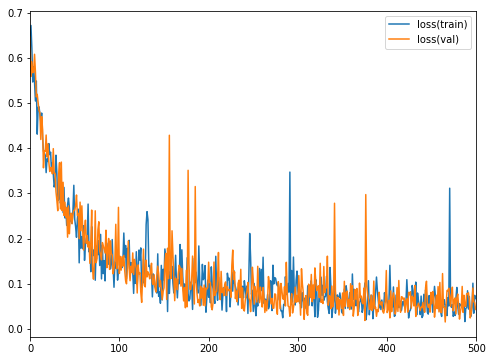

In [16]:
plt.figure(figsize=(8,6))
plt.plot(range(num_steps), stats[:,0], label="loss(train)")
plt.plot(range(num_steps), stats[:,2], label="loss(val)")
plt.legend()
plt.xlim(0, num_steps)
plt.savefig("loss.pdf")
plt.show()

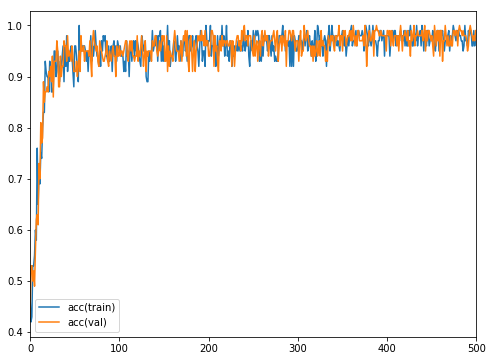

In [17]:
plt.figure(figsize=(8,6))
plt.plot(range(num_steps), stats[:,1], label="acc(train)")
plt.plot(range(num_steps), stats[:,3], label="acc(val)")
plt.legend()
plt.xlim(0, num_steps)
plt.savefig("acc.pdf")
plt.show()